In [452]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import r2_score


plt.rcParams['figure.figsize'] = (27,15)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Set figure size

In [453]:
def plot_timeseries(df, title="", ylim=True):
  
    
    df.plot(linestyle='-', marker=None)
    plt.title(title)
    if ylim:
        plt.ylim(ymin=-20)
    plt.ylabel("temp")
    plt.show()

# Read & pre-processing on train data

In [454]:
df_train = pd.read_csv('df_train.csv')

In [455]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    20088 non-null  object 
 1   temp    20088 non-null  float64
dtypes: float64(1), object(1)
memory usage: 314.0+ KB


In [456]:
df_train['date'] = df_train['date'].astype(str)
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['timestep'] = list(range(df_train.shape[0]))

In [457]:
df_train = df_train.set_index('date')

In [458]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20088 entries, 1965-01-01 to 2019-12-31
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   temp      20088 non-null  float64
 1   timestep  20088 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 470.8 KB


In [459]:
seasonal_dummies = pd.get_dummies(df_train.index.month,
                                  prefix='month',
                                  drop_first=False).set_index(df_train.index)

df_train = df_train.join(seasonal_dummies)

In [460]:
df_train

,temp,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,
1965-01-01,4.9,0,1,0,0,0,0,0,0,0,0,0,0,0
1965-01-02,2.8,1,1,0,0,0,0,0,0,0,0,0,0,0
1965-01-03,1.4,2,1,0,0,0,0,0,0,0,0,0,0,0
1965-01-04,-0.9,3,1,0,0,0,0,0,0,0,0,0,0,0
1965-01-05,2.4,4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,2.8,20083,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-28,0.8,20084,0,0,0,0,0,0,0,0,0,0,0,1
2019-12-29,-0.4,20085,0,0,0,0,0,0,0,0,0,0,0,1


# Break up features & label on train data

In [461]:
X = df_train.drop(df_train[['temp']],axis=1)
y = df_train['temp']

# Modeling for decompose trend & seasenality

In [462]:
m_trend_seasonal = LinearRegression()

In [463]:
m_trend_seasonal.fit(X, y)

df_train['trend_seasonal'] = m_trend_seasonal.predict(X)

df_train.head()

,temp,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,,
1965-01-01,4.9,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.344250
1965-01-02,2.8,1,1,0,0,0,0,0,0,0,0,0,0,0,-0.344151
1965-01-03,1.4,2,1,0,0,0,0,0,0,0,0,0,0,0,-0.344053
1965-01-04,-0.9,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.343955
1965-01-05,2.4,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.343856


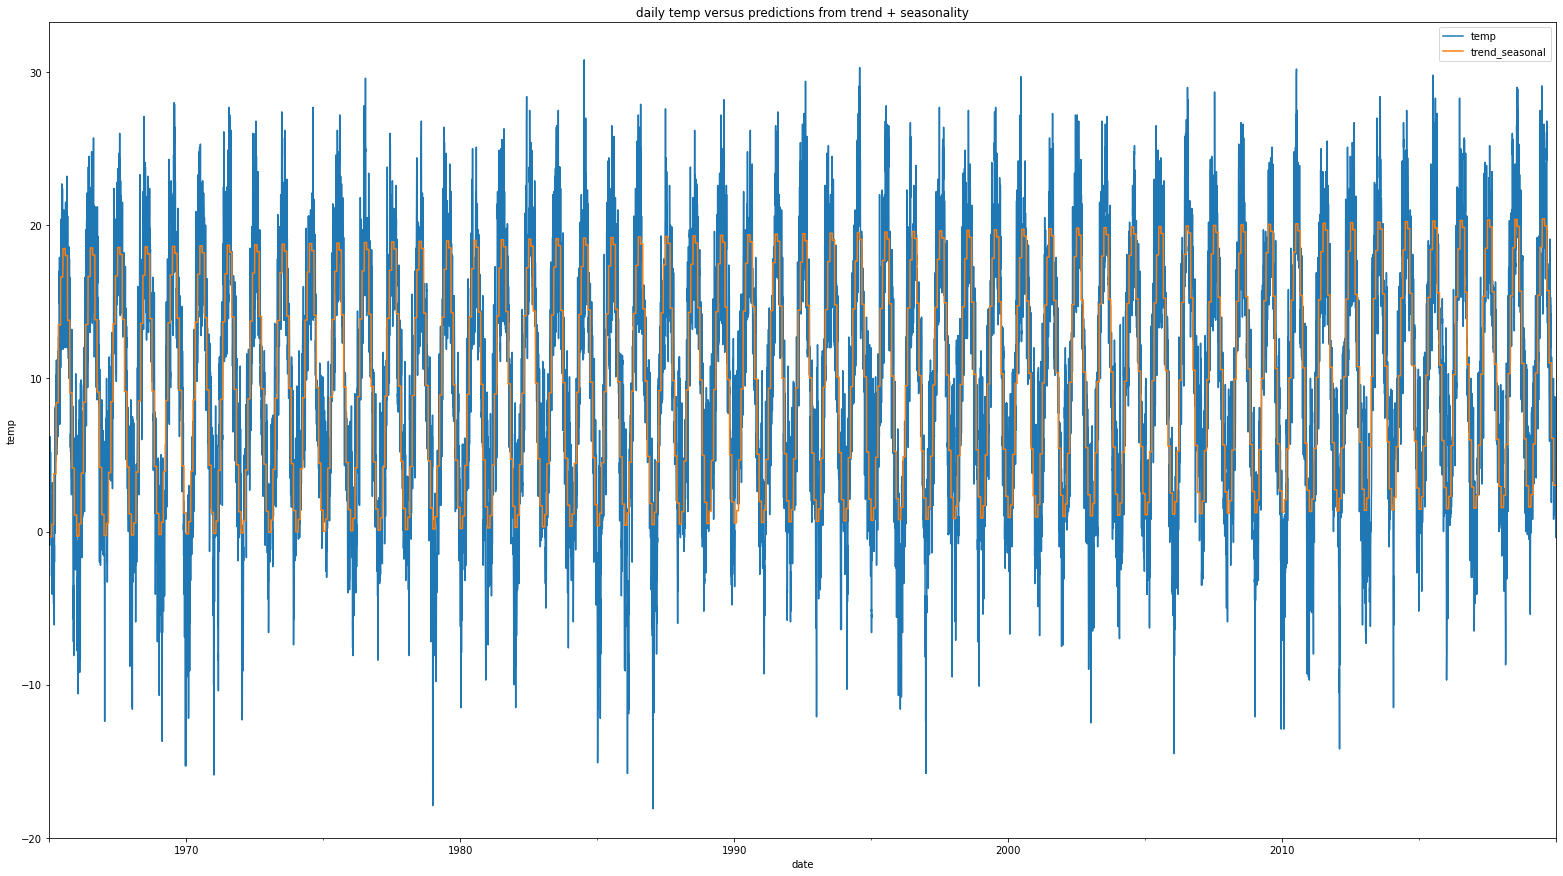

In [464]:
plot_timeseries(df_train[['temp', 'trend_seasonal']], 
                title="daily temp versus predictions from trend + seasonality")

# Extract remainder and add to dataframe

In [465]:
df_train['remainder'] = df_train['temp'] - df_train['trend_seasonal']

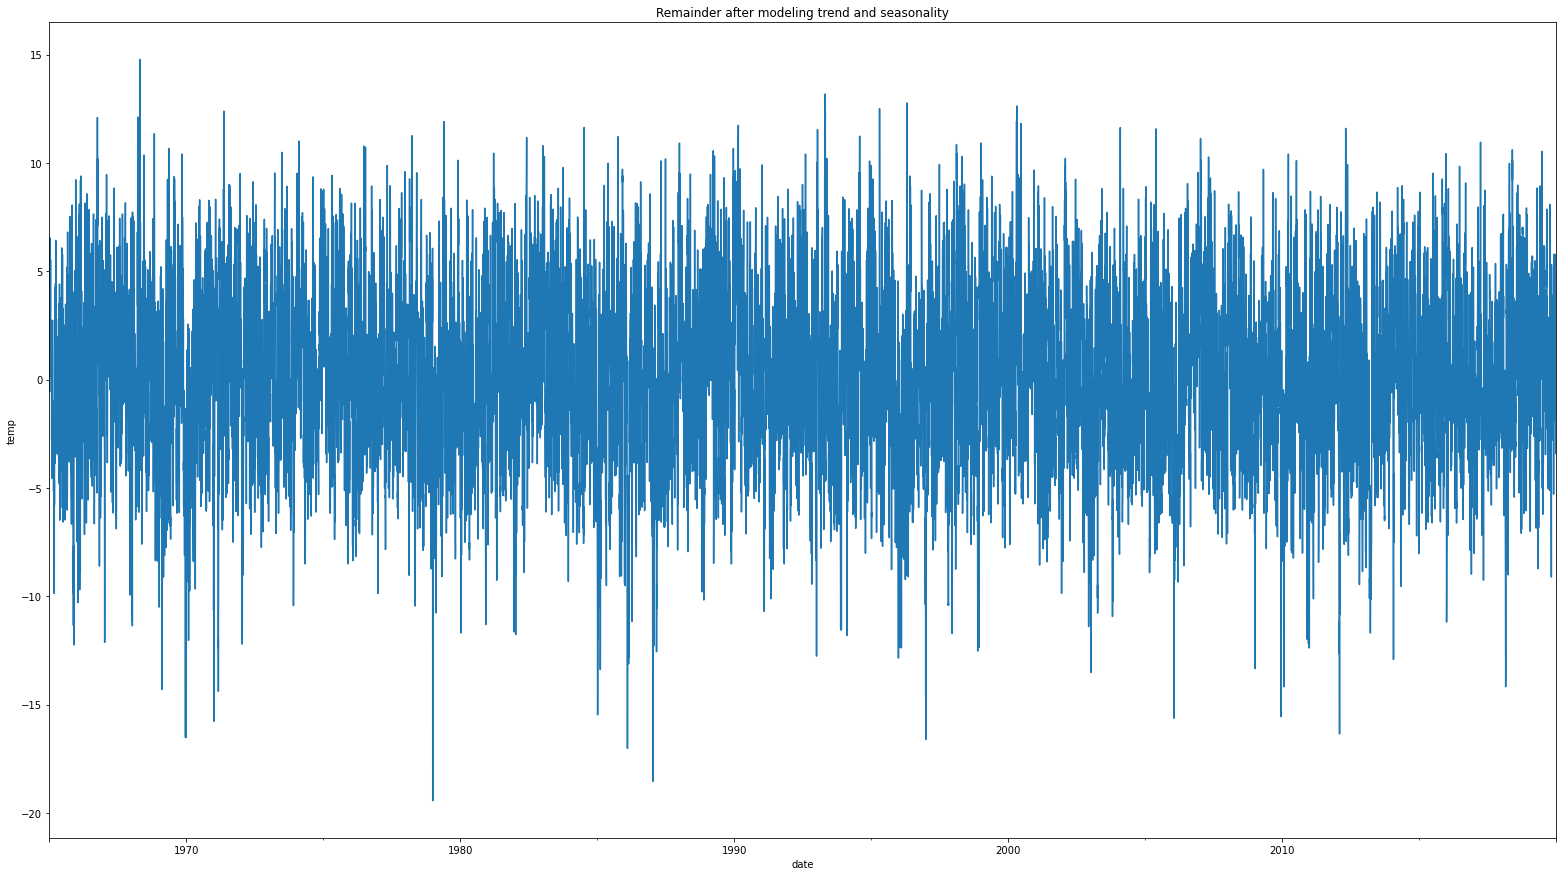

In [466]:
plot_timeseries(df_train['remainder'], title="Remainder after modeling trend and seasonality", ylim=False)

In [467]:
df_train['remainder'].std(), df_train['remainder'].mean()

(3.9823748964844428, 8.697852385673469e-16)

In [468]:
remainder = df_train[['remainder']].copy()
remainder

,remainder
date,
1965-01-01,5.244250
1965-01-02,3.144151
1965-01-03,1.744053
1965-01-04,-0.556045
1965-01-05,2.743856
...,...
2019-12-27,-0.214237
2019-12-28,-2.214336
2019-12-29,-3.414434


# Is it stationary?

In [469]:
import statsmodels
from statsmodels.tsa import stattools

In [470]:
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = \
            statsmodels.tsa.stattools.adfuller(data)
    
    print(f"""   
            adf: {round(adf_stats,2)}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            {round(levels['1%'],2)} (p=1; CI=99%) 
            {round(levels['5%'],2)} (p=5; CI=95%)
            {round(levels['10%'],2)} (p=10 CI=90%) 
            information criterion (AIC): {information_criterion}
            """)
   

In [471]:
print_adf(remainder)

   
            adf: -38.01
            p: 0.0 
            used lag: 5 
            number of observations: 20082
            -3.43 (p=1; CI=99%) 
            -2.86 (p=5; CI=95%)
            -2.57 (p=10 CI=90%) 
            information criterion (AIC): 91490.85655832241
            


 # YES, adf is less than critical values, means we can reject the null hypothesis and infer that the remainder is stationary. 

# Find out which model performs better

## AutoReg ?

In [502]:
stats_ar = AutoReg(remainder['remainder'], lags=3).fit()
stats_ar.summary()

/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                20088
Model:                     AutoReg(3)   Log Likelihood              -45835.576
Method:               Conditional MLE   S.D. of innovations              2.371
Date:                Thu, 27 Jan 2022   AIC                              1.727
Time:                        13:41:05   BIC                              1.729
Sample:                    01-04-1965   HQIC                             1.727
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -9.333e-05      0.017     -0.006      0.996      -0.033       0.033
remainder.L1     0.9122      0.007    129.661      0.000       0.898       0.926
remainder.L2    -0.1994      0.009    -21.140      0.000      -0.218      -0.181
remainder.L3     0.0769      0.007     10.924      0.000       0.063       0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2773           -0.0000j            1.2773           -0.0000
AR.2            0.6585           -3.1230j            3.1917           -0.2169
AR.3            0.6585           +3.1230j            3.1917            0.2169
-----------------------------------------------------------------------------
"""

# Find out how many lags to include in our AR model

## using plot_acf

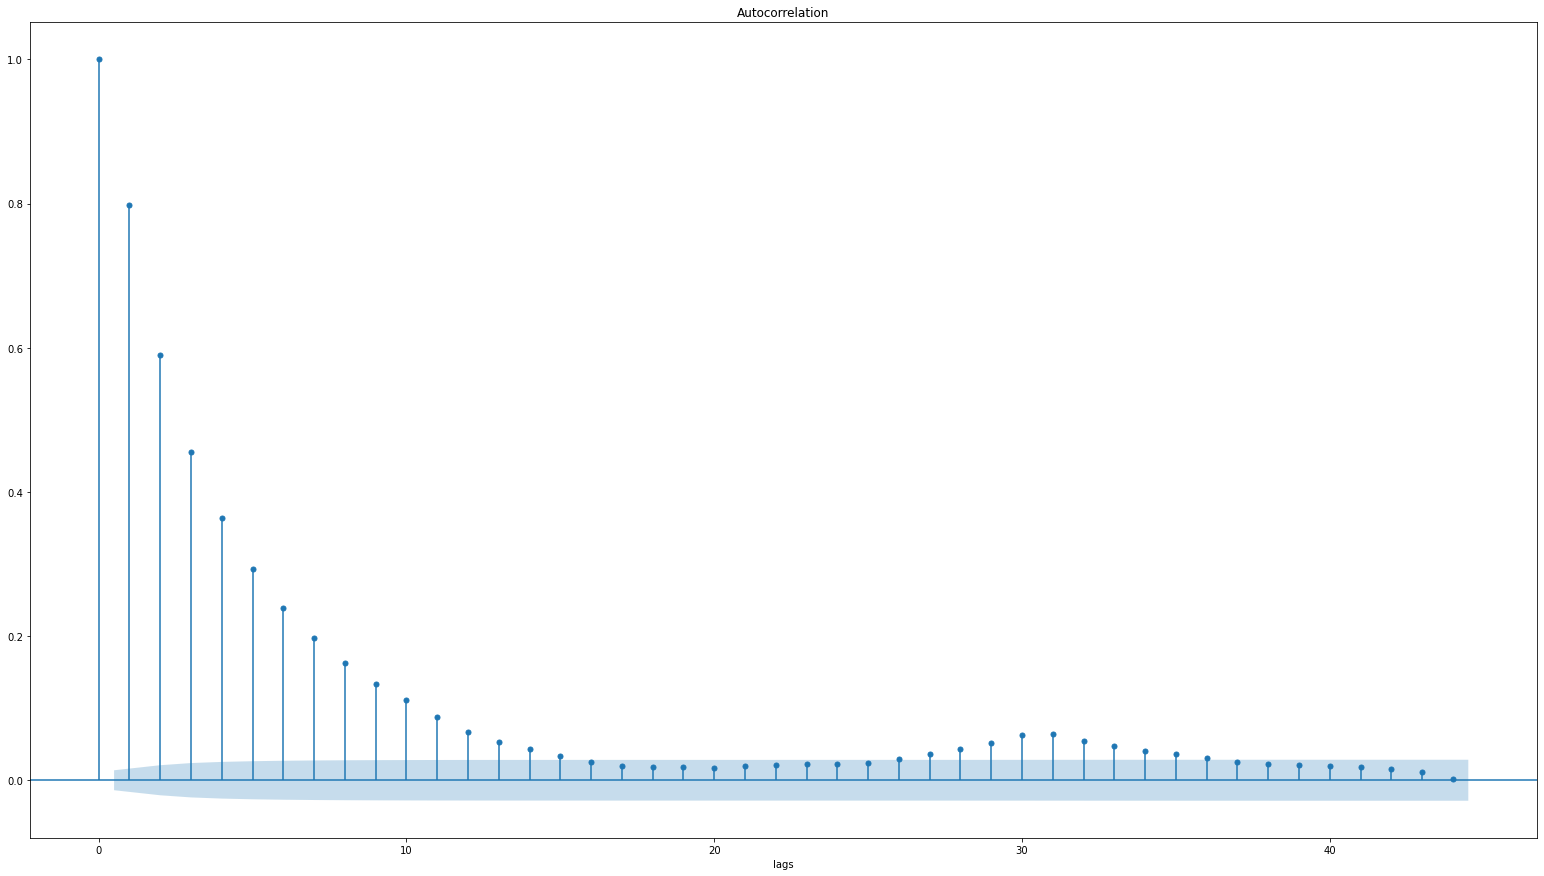

In [472]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(remainder['remainder'])
plt.xlabel('lags');

plt.show()

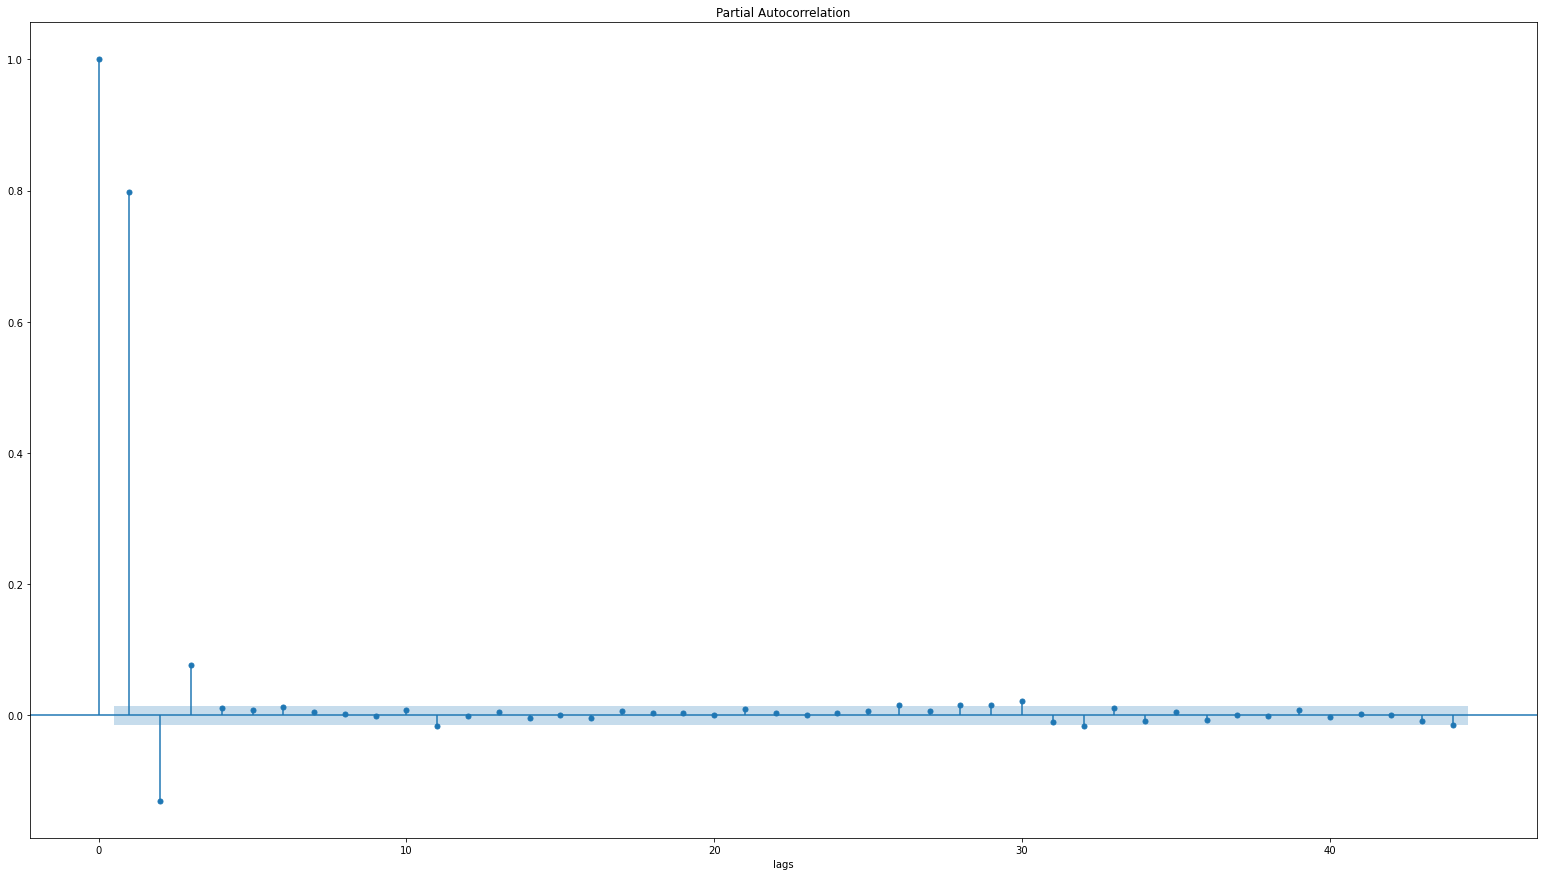

In [473]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(remainder['remainder'])
plt.xlabel('lags');

plt.show()

## using AutoReg, ar_select_order

In [474]:
selected_order = ar_select_order(remainder['remainder'], maxlag = 12)
selected_order.ar_lags

/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


array([1, 2, 3])

In [475]:
stats_ar = AutoReg(remainder['remainder'], lags=3).fit()
stats_ar.summary()

/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                20088
Model:                     AutoReg(3)   Log Likelihood              -45835.576
Method:               Conditional MLE   S.D. of innovations              2.371
Date:                Thu, 27 Jan 2022   AIC                              1.727
Time:                        13:37:51   BIC                              1.729
Sample:                    01-04-1965   HQIC                             1.727
                         - 12-31-2019                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -9.333e-05      0.017     -0.006      0.996      -0.033       0.033
remainder.L1     0.9122      0.007    129.661      0.000       0.898       0.926
remainder.L2    -0.1994      0.009    -21.140      0.000      -0.218      -0.181
remainder.L3     0.0769      0.007     10.924      0.000       0.063       0.091
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2773           -0.0000j            1.2773           -0.0000
AR.2            0.6585           -3.1230j            3.1917           -0.2169
AR.3            0.6585           +3.1230j            3.1917            0.2169
-----------------------------------------------------------------------------
"""

In [476]:
stats_ar.predict()

/Users/Disalo/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


1965-01-01         NaN
1965-01-02         NaN
1965-01-03         NaN
1965-01-04    1.366985
1965-01-05   -0.613405
                ...   
2019-12-27    1.240175
2019-12-28   -0.343710
2019-12-29   -1.855405
2019-12-30   -2.689692
2019-12-31    2.047979
Freq: D, Length: 20088, dtype: float64

In [477]:
df_train['lag1'] = df_train['remainder'].shift(1)
df_train['lag2'] = df_train['remainder'].shift(2)
df_train['lag3'] = df_train['remainder'].shift(3)

df_train.dropna(inplace=True)

df_train.head()


,temp,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
1965-01-04,-0.9,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.343955,-0.556045,1.744053,3.144151,5.244250
1965-01-05,2.4,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.343856,2.743856,-0.556045,1.744053,3.144151
1965-01-06,0.4,5,1,0,0,0,0,0,0,0,0,0,0,0,-0.343758,0.743758,2.743856,-0.556045,1.744053
1965-01-07,-0.2,6,1,0,0,0,0,0,0,0,0,0,0,0,-0.343659,0.143659,0.743758,2.743856,-0.556045
1965-01-08,6.2,7,1,0,0,0,0,0,0,0,0,0,0,0,-0.343561,6.543561,0.143659,0.743758,2.743856


In [478]:
X_lag3 = df_train.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
y = df_train['temp']

In [479]:
X_lag3

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,
1965-01-04,3,1,0,0,0,0,0,0,0,0,0,0,0,1.744053,3.144151,5.244250
1965-01-05,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.556045,1.744053,3.144151
1965-01-06,5,1,0,0,0,0,0,0,0,0,0,0,0,2.743856,-0.556045,1.744053
1965-01-07,6,1,0,0,0,0,0,0,0,0,0,0,0,0.743758,2.743856,-0.556045
1965-01-08,7,1,0,0,0,0,0,0,0,0,0,0,0,0.143659,0.743758,2.743856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,20083,0,0,0,0,0,0,0,0,0,0,0,1,1.585861,2.185959,2.986058
2019-12-28,20084,0,0,0,0,0,0,0,0,0,0,0,1,-0.214237,1.585861,2.185959
2019-12-29,20085,0,0,0,0,0,0,0,0,0,0,0,1,-2.214336,-0.214237,1.585861


# Train the full linear auto-regression model on the training data

In [480]:
X = df_train.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)
y = df_train['temp']

m_full = LinearRegression()

In [481]:
m_full.fit(X,y)
df_train['predictions_full'] = m_full.predict(X)
df_train.head()

,temp,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
1965-01-04,-0.9,3,1,0,0,0,0,0,0,0,0,0,0,0,-0.343955,-0.556045,1.744053,3.144151,5.244250,1.065002
1965-01-05,2.4,4,1,0,0,0,0,0,0,0,0,0,0,0,-0.343856,2.743856,-0.556045,1.744053,3.144151,-0.915651
1965-01-06,0.4,5,1,0,0,0,0,0,0,0,0,0,0,0,-0.343758,0.743758,2.743856,-0.556045,1.744053,2.444868
1965-01-07,-0.2,6,1,0,0,0,0,0,0,0,0,0,0,0,-0.343659,0.143659,0.743758,2.743856,-0.556045,-0.214502
1965-01-08,6.2,7,1,0,0,0,0,0,0,0,0,0,0,0,-0.343561,6.543561,0.143659,0.743758,2.743856,-0.108611


In [483]:
pd.DataFrame(m_full.coef_.reshape(1,16), columns=X.columns)

,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1,lag2,lag3
0,0.000099,-9.200605,-8.409078,-5.094004,-0.488535,4.536422,7.678812,9.572564,9.036448,4.847944,0.136885,-4.781617,-7.835236,0.912105,-0.199346,0.077103


In [484]:
print(r2_score(df_train['temp'], df_train['trend_seasonal']))

print(r2_score(df_train['temp'], df_train['predictions_full']))

0.7431104576541763
0.908984587679229


# Cross-Validation for Forecasting

In [485]:
ts_split = TimeSeriesSplit(n_splits=5)

time_cv = ts_split.split(X, y)

In [486]:
time_cv = ts_split.split(X, y)

estimator = LinearRegression() # instanciate 

r_squared_scores = cross_val_score(estimator=estimator, X=X, y=y, cv=time_cv )

print(r_squared_scores)
print(r_squared_scores.mean())

[0.9070119  0.89973925 0.90349047 0.91928851 0.91675295]
0.9092566145959162


# Apply trained model on test data

In [487]:
df_test = pd.read_csv('df_test.csv')

In [488]:
df_test['date'] = df_test['date'].astype(str)
df_test['date'] = pd.to_datetime(df_test['date'])
df_test = df_test.set_index('date')
df_test['timestep'] = list(range(df_test.shape[0]))

In [489]:
df_test.head()

,temp,timestep
date,,
2020-01-01,1.7,0
2020-01-02,0.5,1
2020-01-03,4.5,2
2020-01-04,3.9,3
2020-01-05,1.2,4


In [490]:
df_test['month'] = df_test.index.month_name()

df_test = pd.get_dummies(df_test, prefix='', prefix_sep='')

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,,
2020-01-01,1.7,0,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-02,0.5,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,4.5,2,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-04,3.9,3,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-05,1.2,4,0,0,0,0,1,0,0,0,0,0,0,0


In [491]:
X_test = df_test.drop('temp', axis=1)
X_test.head()

,timestep,April,August,December,February,January,July,June,March,May,November,October,September
date,,,,,,,,,,,,,
2020-01-01,0,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-02,1,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-03,2,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-04,3,0,0,0,0,1,0,0,0,0,0,0,0
2020-01-05,4,0,0,0,0,1,0,0,0,0,0,0,0


In [492]:
df_test['trend_seasonal'] = m_trend_seasonal.predict(X_test)

In [493]:
df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal
date,,,,,,,,,,,,,,,
2020-01-01,1.7,0,0,0,0,0,1,0,0,0,0,0,0,0,13.473125
2020-01-02,0.5,1,0,0,0,0,1,0,0,0,0,0,0,0,13.473223
2020-01-03,4.5,2,0,0,0,0,1,0,0,0,0,0,0,0,13.473321
2020-01-04,3.9,3,0,0,0,0,1,0,0,0,0,0,0,0,13.473420
2020-01-05,1.2,4,0,0,0,0,1,0,0,0,0,0,0,0,13.473518


In [494]:
df_test['remainder'] = df_test['temp'] - df_test['trend_seasonal']

# Create the lagged variable
df_test['lag1'] = df_test['remainder'].shift(1)
df_test['lag2'] = df_test['remainder'].shift(2)
df_test['lag3'] = df_test['remainder'].shift(3)

df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,0,0,0,0,0,1,0,0,0,0,0,0,0,13.473125,-11.773125,NaN,NaN,NaN
2020-01-02,0.5,1,0,0,0,0,1,0,0,0,0,0,0,0,13.473223,-12.973223,-11.773125,NaN,NaN
2020-01-03,4.5,2,0,0,0,0,1,0,0,0,0,0,0,0,13.473321,-8.973321,-12.973223,-11.773125,NaN
2020-01-04,3.9,3,0,0,0,0,1,0,0,0,0,0,0,0,13.473420,-9.573420,-8.973321,-12.973223,-11.773125
2020-01-05,1.2,4,0,0,0,0,1,0,0,0,0,0,0,0,13.473518,-12.273518,-9.573420,-8.973321,-12.973223


In [495]:
df_train.tail()

,temp,timestep,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2019-12-27,2.8,20083,0,0,0,0,0,0,0,0,0,0,0,1,3.014237,-0.214237,1.585861,2.185959,2.986058,4.281463
2019-12-28,0.8,20084,0,0,0,0,0,0,0,0,0,0,0,1,3.014336,-2.214336,-0.214237,1.585861,2.185959,2.697620
2019-12-29,-0.4,20085,0,0,0,0,0,0,0,0,0,0,0,1,3.014434,-3.414434,-2.214336,-0.214237,1.585861,1.185992
2019-12-30,4.7,20086,0,0,0,0,0,0,0,0,0,0,0,1,3.014533,1.685467,-3.414434,-2.214336,-0.214237,0.351393
2019-12-31,5.7,20087,0,0,0,0,0,0,0,0,0,0,0,1,3.014631,2.685369,1.685467,-3.414434,-2.214336,5.088158


In [496]:
df_test.loc['2020-01-01', 'lag1'] = df_train.loc['2019-12-31', 'remainder']
df_test.loc['2020-01-01', 'lag2'] = df_train.loc['2019-12-30', 'remainder']
df_test.loc['2020-01-01', 'lag3'] = df_train.loc['2019-12-29', 'remainder']

df_test.loc['2020-01-02', 'lag2'] = df_test.loc['2020-01-01', 'lag1']
df_test.loc['2020-01-02', 'lag3'] = df_test.loc['2020-01-01', 'lag2']

df_test.loc['2020-01-03', 'lag3'] = df_test.loc['2020-01-02', 'lag2']


In [497]:
df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3
date,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,0,0,0,0,0,1,0,0,0,0,0,0,0,13.473125,-11.773125,2.685369,1.685467,-3.414434
2020-01-02,0.5,1,0,0,0,0,1,0,0,0,0,0,0,0,13.473223,-12.973223,-11.773125,2.685369,1.685467
2020-01-03,4.5,2,0,0,0,0,1,0,0,0,0,0,0,0,13.473321,-8.973321,-12.973223,-11.773125,2.685369
2020-01-04,3.9,3,0,0,0,0,1,0,0,0,0,0,0,0,13.473420,-9.573420,-8.973321,-12.973223,-11.773125
2020-01-05,1.2,4,0,0,0,0,1,0,0,0,0,0,0,0,13.473518,-12.273518,-9.573420,-8.973321,-12.973223


In [498]:
X_test = df_test.drop(['temp', 'trend_seasonal', 'remainder'], axis=1)

df_test['predictions_full'] = m_full.predict(X_test)

In [499]:
df_test.head()

,temp,timestep,April,August,December,February,January,July,June,March,May,November,October,September,trend_seasonal,remainder,lag1,lag2,lag3,predictions_full
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.7,0,0,0,0,0,1,0,0,0,0,0,0,0,13.473125,-11.773125,2.685369,1.685467,-3.414434,15.283481
2020-01-02,0.5,1,0,0,0,0,1,0,0,0,0,0,0,0,13.473223,-12.973223,-11.773125,2.685369,1.685467,2.289808
2020-01-03,4.5,2,0,0,0,0,1,0,0,0,0,0,0,0,13.473321,-8.973321,-12.973223,-11.773125,2.685369,4.154633
2020-01-04,3.9,3,0,0,0,0,1,0,0,0,0,0,0,0,13.473420,-9.573420,-8.973321,-12.973223,-11.773125,6.927498
2020-01-05,1.2,4,0,0,0,0,1,0,0,0,0,0,0,0,13.473518,-12.273518,-9.573420,-8.973321,-12.973223,5.490347


In [500]:
print(r2_score(df_test['temp'], df_test['predictions_full'])) # score of the full model

0.7416028566827246
